In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpyro
numpyro.set_host_device_count(4)
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pytensor.tensor as pt


from foottraffic.awb_model.models.priormodel import DelayedAdStockPrior, LocalTrendPrior
from foottraffic.awb_model.models.variablemodels import MediaVariableDetails, LocalTrendsVariableDetails

from foottraffic.awb_model.models.dataloading import MFF
from foottraffic.bayes.media_transforms.adstock import delayed_adstock, delayed_adstock_weights

In [3]:
def ar1_cov(t_0, t_1, rho=.5, sigma=1):
    """
    Compute the covariance of an AR1 process.
    """
    return sigma**2/(1 - rho**2) * np.exp(np.abs(t_1 - t_0) * np.log(rho))

cov_mat = np.array(
    [[ar1_cov(i, j, rho=.8) for i in range(156)] for j in range(156)]
)

In [4]:
group_map = {
  "Northeast": ['NY', "NJ"],
  "West": ["WA", "OR", "CA"],
  "South": ["TX", "FL", "GA", "MS"]
  }
geos = [i for _, item in group_map.items() for i in item]
np.random.shuffle(geos)
splines = np.array([[1 if name in group else 0 for key, group in group_map.items()] for name in geos])@np.array([[1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]])

In [5]:
geos

['CA', 'OR', 'GA', 'NY', 'WA', 'TX', 'NJ', 'FL', 'MS']

In [6]:
time_range = pd.date_range('2020-01-01', periods=52*3, freq="W-MON")

In [7]:
index_frame = pd.DataFrame({"Period": np.tile(time_range, len(geos)), 'Geography': np.repeat(geos, len(time_range))})

In [8]:
index_frame['VariableValue'] = np.tile(np.random.normal(0, 3, size=156), len(geos))

In [9]:
index_frame["VariableName"] = "Time Specific Feature"
index_frame["Product"] = "Total"
index_frame["Outlet"] = "Total"
index_frame['Campaign'] = "Total"
index_frame['Creative'] = 'Total'

In [10]:
mff = MFF(data=index_frame)

In [11]:
llt_var = LocalTrendsVariableDetails(variable_name="LLT", random_coeff_dims=["Geography"], grouping_map=group_map, grouping_name="Region")

In [29]:
coords = {
    "Period": time_range,
    "Geography": geos
}
with pm.Model(coords=coords) as model:
    contribution = llt_var.get_contributions(mff)

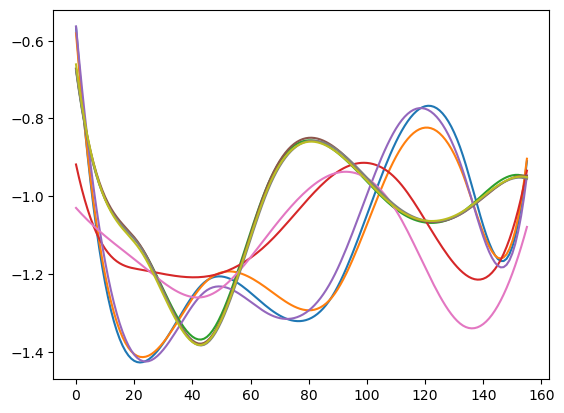

In [30]:
plt.plot(pm.draw(contribution).T)

In [14]:
from patsy import dmatrix

In [15]:
def spline_matrix(data: pd.DataFrame, geo: str, n_knots: int=6, order: int=3):

  t = np.linspace(0, 1, len(data[geo].unique()))
  knots = np.linspace(0, 1, n_knots+2)[1:-1]
  
  B0 = dmatrix("bs(t, knots=knots, degree=order, include_intercept=True) - 1", 
             {"t": t, "knots": knots, "order": order})
  return np.asarray(B0)




In [16]:
spline_matrix(index_frame, "Period", 6).shape

(156, 10)

In [31]:
mff

MFF()

In [84]:
with pm.Model(coords=dict(Period=time_range, Geography=geos, Week=np.unique([date.week for date in time_range]))) as gen_model:
  
  

  #splines = spline_matrix(index_frame, 'Period', (52*3)//12)
  #betas = LocalTrendPrior().build('test', n_splines=splines.shape[1], random_dims=["Geography"], grouping_map=group_map, grouping_name="Region")
  #trend = pm.Deterministic("trend", splines @ betas.T , dims=("Period", "Geography"))
  trend = pm.Deterministic("trend", llt_var.get_contributions(mff), dims=("Geography", "Period"))
  
  time_data_beta = pm.Normal("time_beta", 0, 1)
  time_effect = pm.Deterministic('time_effect', time_data_beta * index_frame["VariableValue"].values.reshape((len(geos), len(time_range))).T, dims=("Period", "Geography"))
  
  holiday_sd = pm.HalfCauchy("holiday_sd", 1, dims='Week')
  tau = pm.HalfNormal('holiday_like', sigma=1)
  holiday_week_mu = pm.Deterministic("holiday_week_mu", tau*holiday_sd*pm.Normal("holiday_week_mu_", 0, 1, dims='Week'), dims="Week")
  holiday_year_diff = pm.HalfNormal("holiday_year", 1)
  holiday_diff = pm.Normal('holiday_diff', 0, 1, dims="Period")
  dates = np.array([date.week-1 for date in time_range])
  holiday_mu = pm.Deterministic("holiday_mu", holiday_week_mu[dates]*pm.math.exp(holiday_year_diff*holiday_diff), dims="Period")
  holiday_geo = pm.HalfNormal('holiday_sigma', .4)
  holiday_multiplier = pm.Normal("holiday_mult", 0, 1, dims=("Geography"))

  holiday_effect = pm.Deterministic("holiday", holiday_mu[:, None] * pm.math.exp(holiday_geo*holiday_multiplier), dims=("Period", "Geography"))

  intercept_mu = pm.Normal("intercept_mu", 0, 1)
  intercept_sd = pm.HalfNormal("intecept_sd", 1, dims="Geography")
  intercept_geo = pm.Normal("intercept", intercept_mu, intercept_sd, dims="Geography")

  mu = pm.Deterministic("mu", intercept_geo[None, :] + holiday_effect + trend.T + time_effect, dims=("Period", "Geography"))
  sigma = pm.HalfNormal("noise", 1)
  observation = pm.Normal("Obs", mu = mu, sigma=sigma, dims=("Period", "Geography"))
  

In [85]:
holiday_det = np.array([10 if (data.week%53==3 or data.week%53==10 or data.week%53==30) else 0 for data in time_range])
holiday_det = np.tile(holiday_det, len(geos)).reshape(len(geos), len(time_range)).T * (1 + np.random.normal(0, .5, size=(len(geos))))

In [86]:
trend.shape.eval()

array([  9, 156])

In [101]:
with pm.do(gen_model, {"noise": .2, "time_beta": 1, 'holiday_like': .03}) as synthetic_model: #"holiday": holiday_det, 'holiday_sigma': .5, 'holiday_like': .2
  prior = pm.sample_prior_predictive()

Sampling: [LLT_LLT::splines_betas, LLT_LLT::splines_betas_group, LLT_LLT::splines_betas_group_sd, LLT_LLT::splines_betas_mu, LLT_LLT::splines_betas_sd, LLT_LLT::tau, Obs, holiday_diff, holiday_mult, holiday_sd, holiday_sigma, holiday_week_mu_, holiday_year, intecept_sd, intercept, intercept_mu]


In [102]:
sample = prior.prior.sel(chain=0, draw=6)

Text(0.5, 0, 'Period')

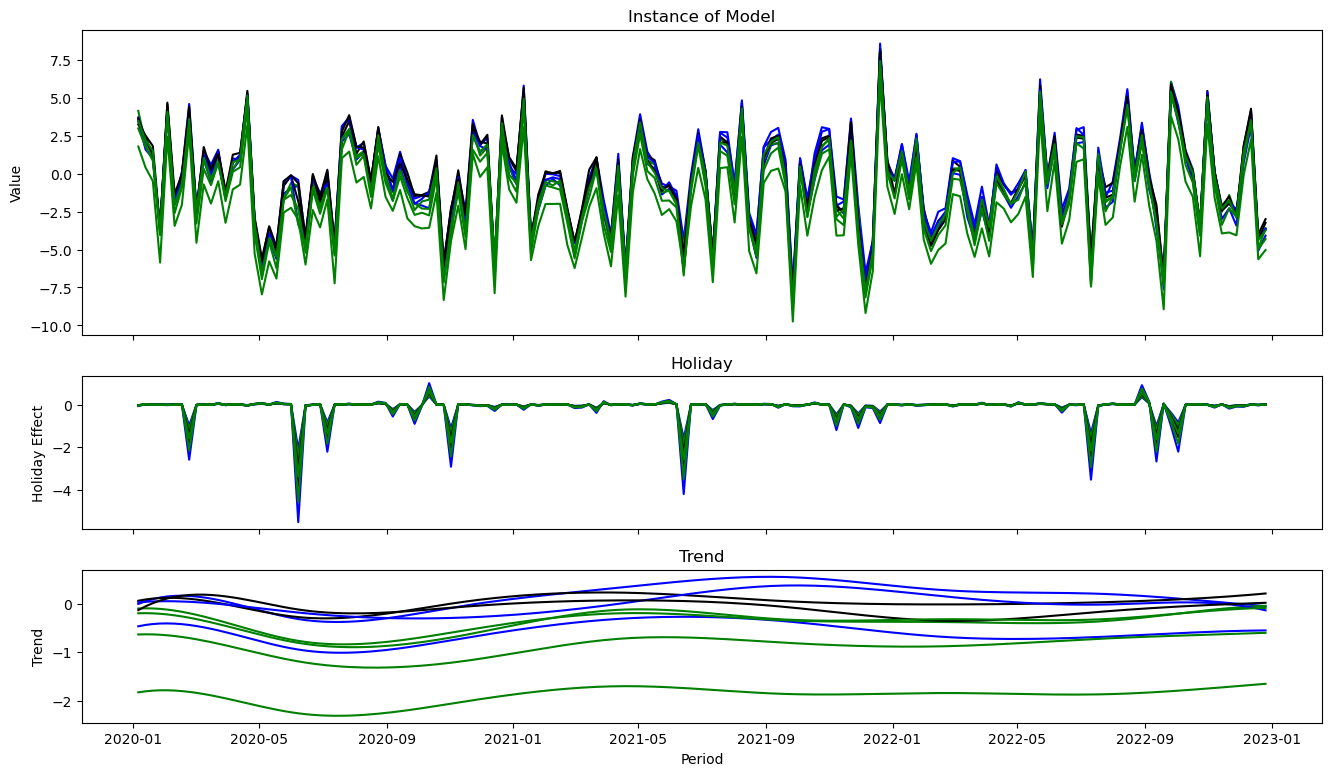

In [103]:
fig, ax = plt.subplots(3, figsize=(16, 9), height_ratios=[2, 1, 1], sharex=True)
for i, geo in enumerate(geos):
  color = 'k' if geo in group_map["Northeast"] else (
    'b' if geo in group_map["West"] else 'g'
  )
  ax[0].plot(time_range, sample.Obs.sel(Geography=geo), c=color)
  ax[2].plot(time_range, sample.trend.sel(Geography=geo) + sample.intercept.sel(Geography=geo), c=color)
  ax[1].plot(time_range, sample.holiday.sel(Geography=geo), c=color)

ax[0].set_title("Instance of Model")
ax[0].set_ylabel("Value")

ax[1].set_title("Holiday")
ax[1].set_ylabel("Holiday Effect")

ax[2].set_title("Trend")
ax[2].set_ylabel("Trend")
ax[2].set_xlabel("Period")

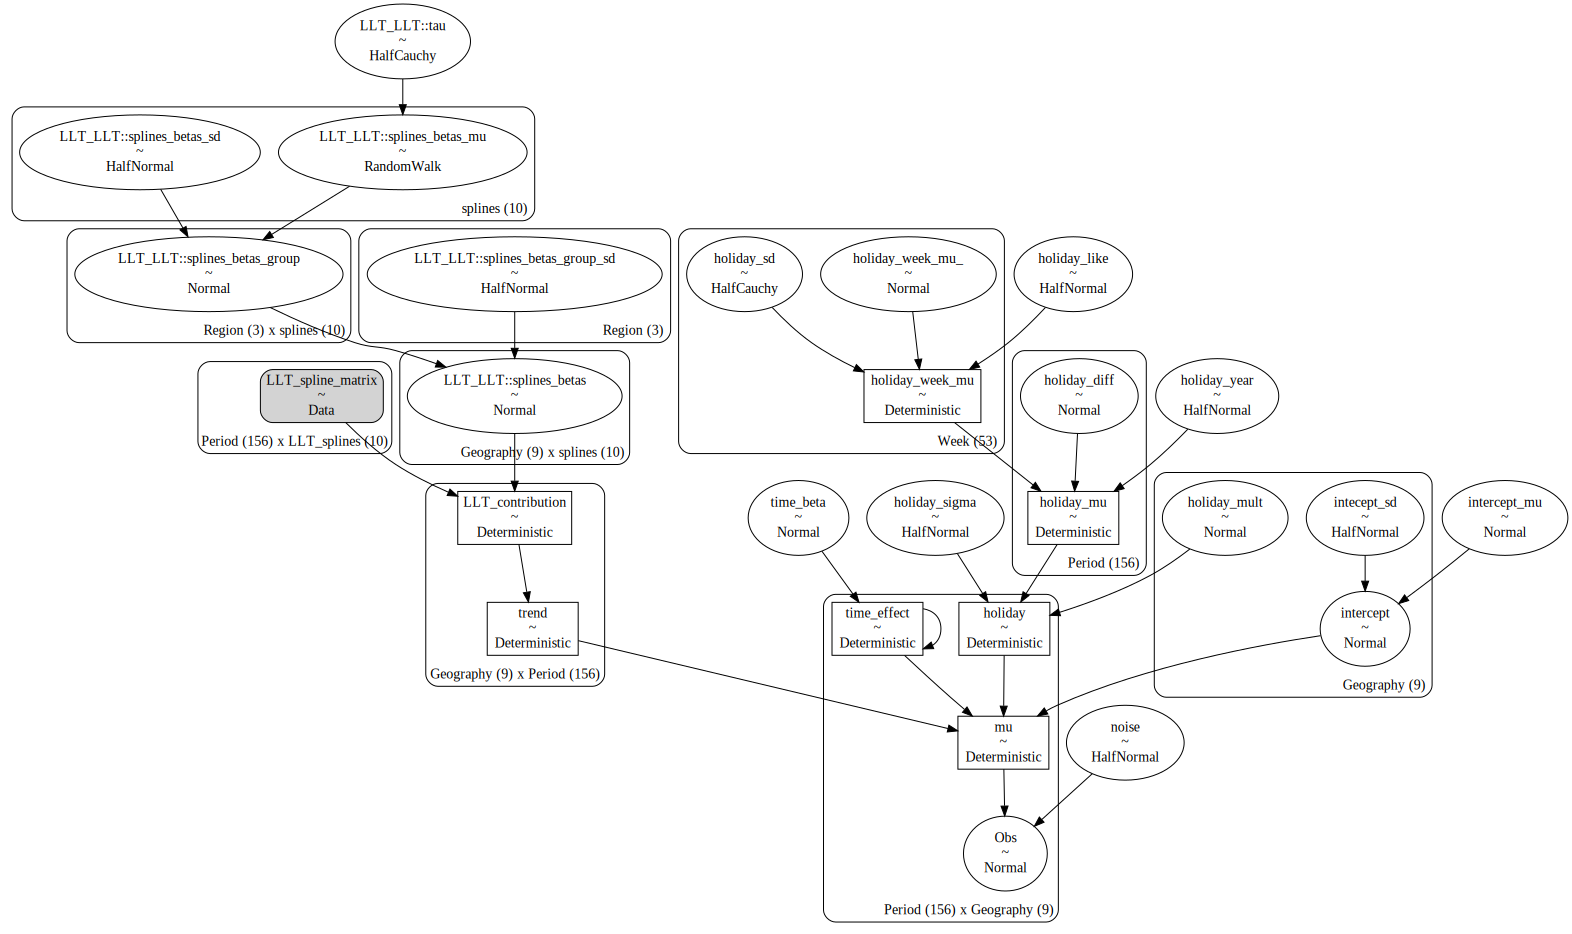

In [104]:
pm.model_to_graphviz(gen_model)

In [105]:
with pm.observe(gen_model, {"Obs": sample.Obs}) as obs_model:
  trace = pm.sample(tune=2000, target_accept=.99, nuts_sampler="numpyro")

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [112]:
with obs_model:
  sample = pm.find_MAP()

Output()

array([[<Axes: title={'center': 'time_beta'}>,
        <Axes: title={'center': 'time_beta'}>]], dtype=object)

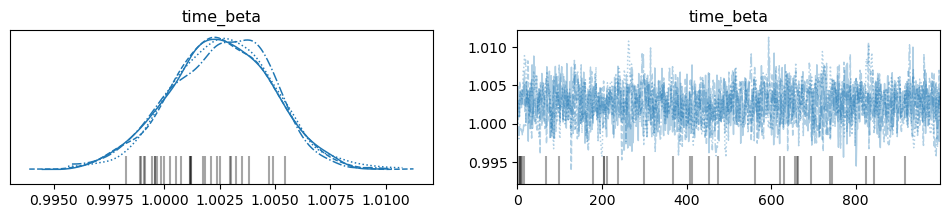

In [113]:
pm.plot_trace(trace, var_names=["time_beta"], filter_vars="regex")

In [107]:
with obs_model:
  posterior = pm.sample_posterior_predictive(trace)

Sampling: [Obs, holiday_diff]


Output()

In [108]:
posterior

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [109]:
geo_to_region_map = {
    geo: key  for key in group_map.keys()  for geo in geos if geo in group_map[key]
}
geo_to_region_map

{'NY': 'Northeast',
 'NJ': 'Northeast',
 'CA': 'West',
 'OR': 'West',
 'WA': 'West',
 'GA': 'South',
 'TX': 'South',
 'FL': 'South',
 'MS': 'South'}

Text(0.5, 0, 'Period')

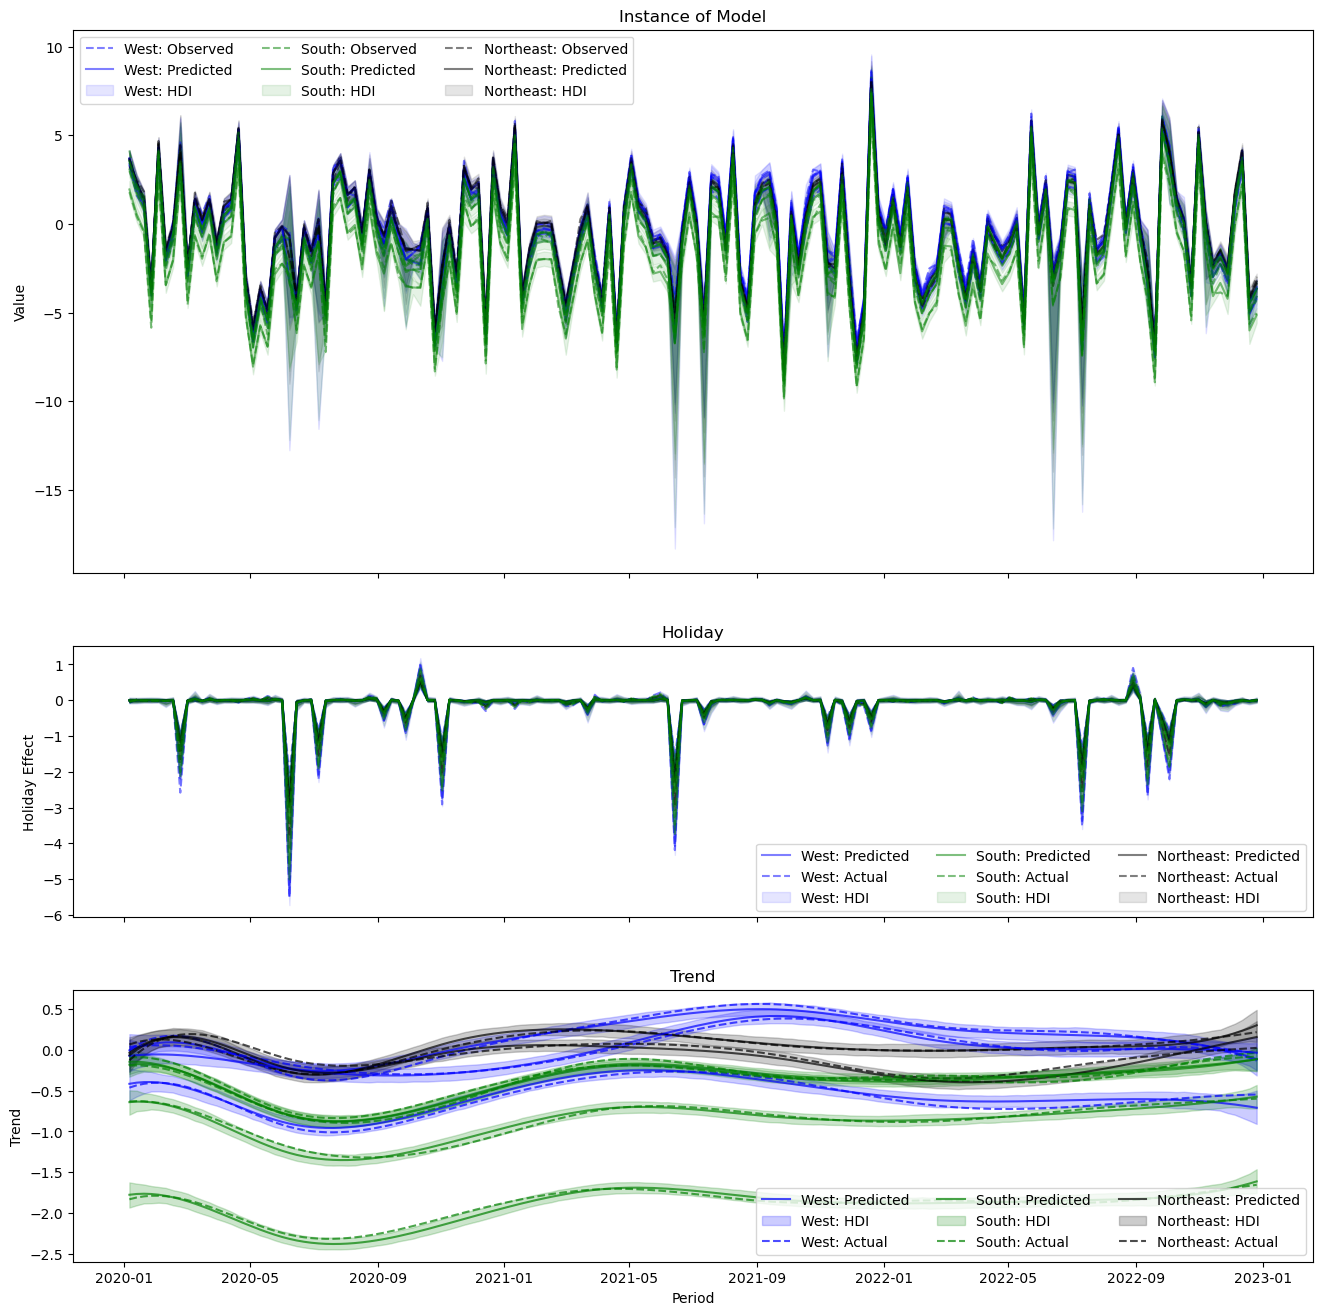

In [110]:
fig, ax = plt.subplots(3, figsize=(16, 16), height_ratios=[2, 1, 1], sharex=True)
trend_hdi = pm.hdi((trace.posterior.trend + trace.posterior.intercept))
sample_hdi = pm.hdi(posterior.posterior_predictive.Obs)
holiday_hdi = pm.hdi(trace.posterior.holiday)
region_seen = []
for i, geo in enumerate(geos):
  color = 'k' if geo in group_map["Northeast"] else (
    'b' if geo in group_map["West"] else 'g'
  )
  region = geo_to_region_map[geo]
  ax[0].plot(time_range, sample.Obs.sel(Geography=geo), c=color, ls='--', alpha=.5, label=f"{region}: Observed" if not region in region_seen else "")
  ax[0].plot(time_range, trace.posterior.mu.mean(dim=("draw", "chain")).sel(Geography=geo), c=color, alpha=.5, label=f"{region}: Predicted" if not region in region_seen else "")
  ax[0].fill_between(time_range, sample_hdi.Obs.sel(Geography=geo, hdi='lower'), sample_hdi.Obs.sel(Geography=geo, hdi='higher'), color=color, alpha=.1, label=f"{region}: HDI" if not region in region_seen else "")
  ax[2].plot(time_range, (trace.posterior.trend.sel(Geography=geo) + trace.posterior.intercept.sel(Geography=geo)).mean(dim=("draw", "chain")), c=color, alpha=.7, label=f"{region}: Predicted" if not region in region_seen else "")
  ax[2].fill_between(time_range, trend_hdi.x.sel(Geography=geo, hdi='lower'), trend_hdi.x.sel(Geography=geo, hdi='higher'), color=color, alpha=.2, label=f"{region}: HDI" if not region in region_seen else "")
  ax[2].plot(time_range, sample.trend.sel(Geography=geo) + sample.intercept.sel(Geography=geo), c=color, ls='--', alpha=.7, label=f"{region}: Actual" if not region in region_seen else "")
  ax[1].plot(time_range, (trace.posterior.holiday.sel(Geography=geo)).mean(dim=("draw", "chain")), c=color, alpha=.5, label=f"{region}: Predicted" if not region in region_seen else "")
  ax[1].plot(time_range, sample.holiday.sel(Geography=geo), c=color, ls='--', alpha=.5, label=f"{region}: Actual" if not region in region_seen else "")
  ax[1].fill_between(time_range, holiday_hdi.holiday.sel(Geography=geo, hdi='lower'), holiday_hdi.holiday.sel(Geography=geo, hdi='higher'), color=color, alpha=.1, label=f"{region}: HDI" if not region in region_seen else "")
  region_seen.append(region)
ax[0].set_title("Instance of Model")
ax[0].legend(ncols=3)
ax[0].set_ylabel("Value")

ax[1].set_title("Holiday")
ax[1].legend(ncols=3)
ax[1].set_ylabel("Holiday Effect")

ax[2].set_title("Trend")
ax[2].legend(ncols=3)
ax[2].set_ylabel("Trend")
ax[2].set_xlabel("Period")

In [9]:
rng = np.random.default_rng(123)

In [10]:
with pm.Model():
    ex = pm.Exponential("test", 1.5)
test_exd = pm.draw(ex, 10000)

<Axes: >

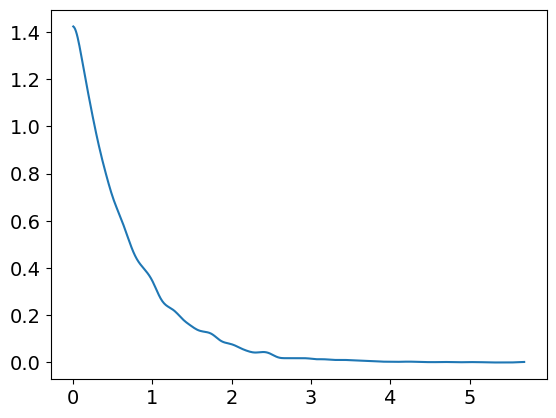

In [11]:
pm.plot_dist(test_exd)

In [12]:
MediaVariableDetails(variable_name="test_media")

MediaVariableDetails(variable_name='test_media', variable_type='media', deterministic_transform=DeterministicTransform(functional_form=<FunctionalForms.linear: 'linear'>, params=None), normalization=<Normilization.none: 'none'>, std=None, mean=None, time_transform=None, sign='positive', partial_pooling_sigma=1, adstock=<Adstock.delayed: 'delayed'>, media_transform=<MediaTransform.hill: 'hill'>, coeff_prior=MediaCoeffPrior(coeff_dist=<PosDist.lognormal: 'LogNormal'>, coeff_params={'mu': -2.995732273553991, 'sigma': 0.26236426446749106}), fixed_ind_coeff_dims=None, random_coeff_dims=None, media_transform_prior=HillPrior(type='Hill', K_ave=0.85, K_std=0.6, n_ave=1.5, n_std=1.2), adstock_prior=DelayedAdStockPrior(type='Delayed', retention_rate_mean=0.2, retention_rate_std=10, lag_min=0.0001, lag_max=3))

In [9]:
adstock_prior = DelayedAdStockPrior()
variable = MediaVariableDetails(variable_name="test_media")
with pm.Model() as model:
    priors_ = adstock_prior.build("test")

In [10]:
data = np.random.gamma(3, 1000, size=(20, 156))

In [11]:
with pm.Model(coords={
    "Geography": np.arange(20),
    "Period": np.arange(156)
}) as test_transform:
    contributions = variable.get_contributions(data)

In [12]:
contributions = pm.draw([test_transform["test_media_retention_rate_log"], test_transform["test_media_lag"], test_transform["test_media_media_transform"], test_transform["test_media_adstock"]])

In [13]:
test_transform.named_vars

{'test_media_fixed_coeff': test_media_fixed_coeff ~ LogNormal(-3, 0.262),
 'test_media_coeff_estimate': test_media_coeff_estimate ~ Deterministic(f(test_media_fixed_coeff)),
 'test_media_positive_sign': test_media_positive_sign ~ Potential(f(test_media_fixed_coeff)),
 'test_media': test_media,
 'test_media_transformed': test_media_transformed ~ Deterministic(f()),
 'test_media_K_': test_media_K_ ~ Normal(-0.163, 0.534),
 'test_media_n_': test_media_n_ ~ Normal(0.405, 0.588),
 'test_media_K': test_media_K ~ Deterministic(f(test_media_K_)),
 'test_media_n': test_media_n ~ Deterministic(f(test_media_n_)),
 'test_media_media_transform': test_media_media_transform ~ Deterministic(f(test_media_n_, test_media_K_)),
 'test_media_retention_rate_log': test_media_retention_rate_log ~ Beta(2, 8),
 'test_media_lag': test_media_lag ~ Exponential(f()),
 'test_media_adstock': test_media_adstock ~ Deterministic(f(test_media_retention_rate_log, test_media_lag, test_media_n_, test_media_K_)),
 'test_medi

In [17]:
contributions[1]

array(0.45027903)

<BarContainer object of 12 artists>

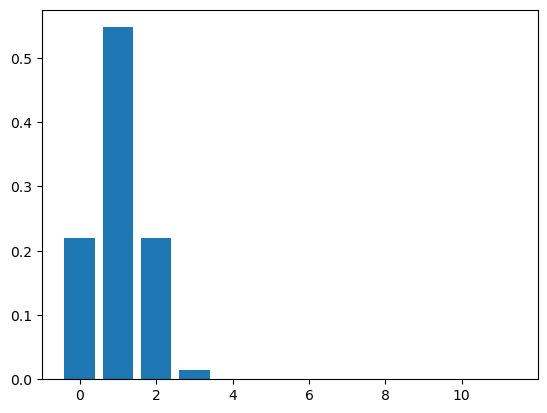

In [18]:
plt.bar(np.arange(12), delayed_adstock_weights(.4, 1).eval())

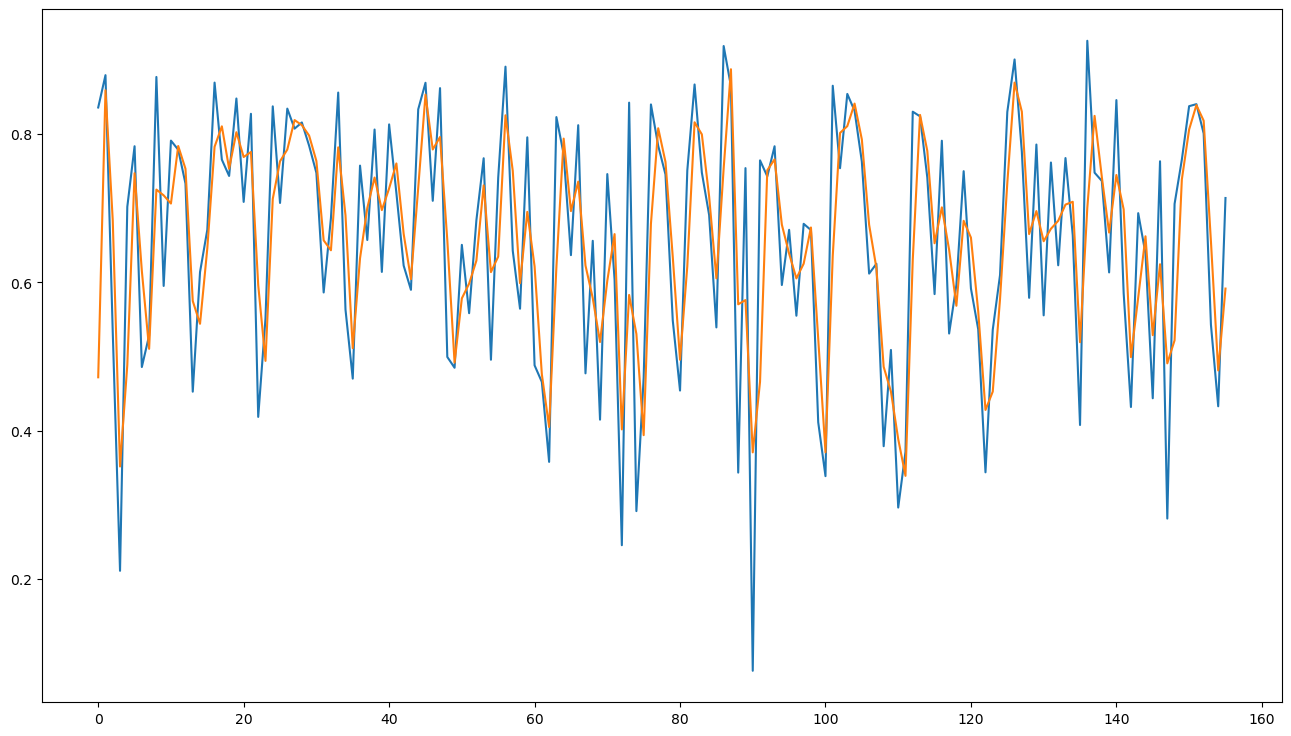

In [15]:
plt.figure(figsize=(16,9))
plt.plot(contributions[2][1, :])
plt.plot(contributions[3][1, :])

In [60]:
alpha, beta = pm.draw(priors_, 100)

In [66]:
ad_stock_weights = delayed_adstock_weights(alpha, beta).eval()

<BarContainer object of 12 artists>

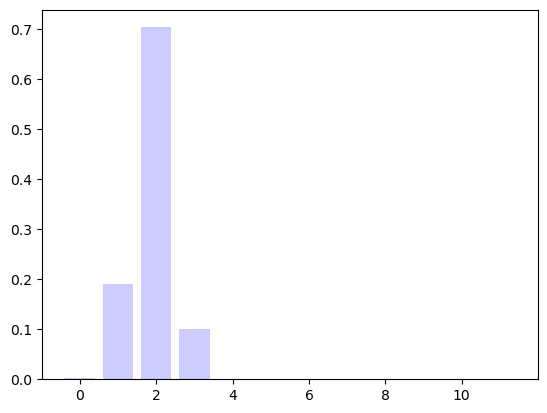

In [98]:
alpha, beta = pm.draw(priors_)
ad_stock_weights = delayed_adstock_weights(alpha, beta).eval()

plt.bar(np.arange(12), ad_stock_weights, alpha=.2, color='blue')

<Axes: >

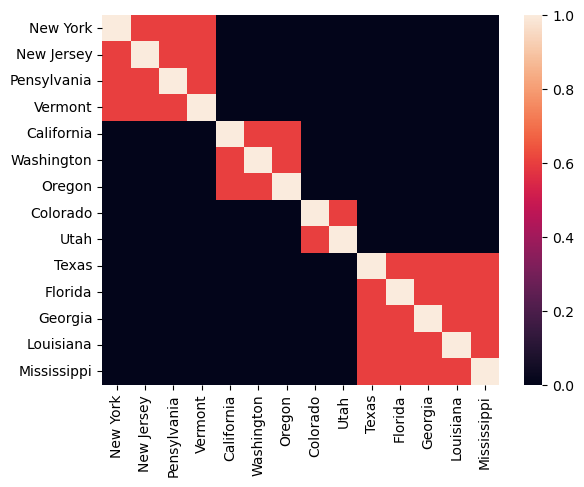

In [4]:
# Time over which to simulate data
time = pd.date_range('2021-01-01', periods=156, freq='W-MON')
# Geographies for which to simulate data
geographies = [
  "New York", "New Jersey", 
  "Pensylvania", "Vermont",
  "California", "Washington",
  "Oregon", "Colorado", 
  "Utah", "Texas",
  "Florida", "Georgia",
  "Louisiana", "Mississippi",
]
# Groupings of geographies
regions = {
  "Northeast": ["New York", "New Jersey", "Pensylvania", "Vermont"],
  "West": ["California", "Washington", "Oregon"],
  "South": ["Texas", "Florida", "Georgia", "Louisiana", "Mississippi"],
  "Mountain": ["Colorado", "Utah"],
}
region_map = {geo: region for region, geos in regions.items() for geo in geos}
# Correlation with region
corr_within = 0.6
corr_between = 0
corr_matrix = np.array([
  [1 if geo1 == geo2 else corr_within if region_map[geo1] == region_map[geo2] else corr_between for geo1 in geographies]
  for geo2 in geographies
])

sns.heatmap(corr_matrix, vmin=0, vmax=1, xticklabels=geographies, yticklabels=geographies)


In [5]:
np.concatenate([np.linspace(i-.2, i+.2, len(regions[key])) for i, key in enumerate(regions.keys())])

array([-0.2       , -0.06666667,  0.06666667,  0.2       ,  0.8       ,
        1.        ,  1.2       ,  1.8       ,  1.9       ,  2.        ,
        2.1       ,  2.2       ,  2.8       ,  3.2       ])

In [6]:
n_gps, n_t = 14, 156
t = np.linspace(0, 156, n_t)
x = np.concatenate([np.linspace(3*i-.5, 3*i+.5, len(regions[key])) for i, key in enumerate(regions.keys())])

eta_true = 1.0
ell_x_true = 1.0
cov_x = eta_true**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell_x_true)
Kx = cov_x(x[:, None])

ell_t_l_true = 52*3
ell_m_l_true = 52
ell_s_l_true = 12
eta_t = 3.0
cov_t_l = eta_t**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell_t_l_true)
cov_t_m = (eta_t/2)**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell_m_l_true)
cov_t_s = (eta_t/4)**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell_s_l_true)
seasonal = pm.gp.cov.Periodic(1, period=52, ls=1) 
cov_t = cov_t_l + cov_t_m + cov_t_s + 3*seasonal
Kt = cov_t(t[:, None])

K = pt.slinalg.kron(Kx, Kt)
f_true = (
    pm.draw(pm.MvNormal.dist(mu=np.zeros(n_gps * n_t), cov=K), random_seed=rng)
    .reshape(n_gps, n_t)
    .T
)

# Additive gaussian noise
sigma_noise = 0.5
noise_dist = pm.Normal.dist(mu=0.0, sigma=sigma_noise)

y_obs = f_true + pm.draw(noise_dist, draws=n_t * n_gps, random_seed=rng).reshape(n_t, n_gps)

In [7]:
geographies_reordered = []
for key in regions.keys():
    geographies_reordered.extend(regions[key])

In [8]:
data = pd.DataFrame(index=time, columns=geographies_reordered, data=y_obs)

In [9]:
mff = (data
  .melt(ignore_index=False)
  .reset_index()
  .rename(
    columns={
      "index": "Period", 
      "variable": "Geography", 
      "value": "VariableValue"
      }
  )
  .assign(Campaign=lambda x: x.Geography.map(region_map))
  .assign(VariableName="sales")
)
mff["Outlet"] = "Test"

In [10]:
mff_columns = set(["Period", "Geography", "Outlet", "Campaign"])
mff_order = ["Period", "Geography", "Outlet", "Campaign"]

In [11]:
columns_to_consider = set(["Outlet"])
group_var = set(['Campaign'])
id_vars = set(["Period", "Geography"])

In [12]:
analytic = mff.pivot(index=[col for col in mff_order if col in id_vars], columns="VariableName" if len((mff_columns - id_vars) - group_var) == 0 else ["VariableName"]+[col for col in mff_order if col in ((mff_columns - id_vars) - group_var)], values="VariableValue" if len(group_var)==0 else ["VariableValue"]+[col for col in mff_order if col in group_var])
analytic.columns = analytic.columns.map(lambda x: "_".join(x))
analytic.reset_index(inplace=True)
analytic.sort_values(by=["Period", "Geography"], inplace=True)

In [13]:
analytic["Campaign_sales_Test"].values.reshape((156, 14))[:,3].shape

(156,)

In [14]:
def pipe_wrapper(f):
  def wrapper(*args, **kwargs):
    output = f(*args, **kwargs)
    if isinstance(output, pd.DataFrame):
      return output
    else:
      f(*args, **kwargs)
      if isinstance(args[0], pd.DataFrame):
        return args[0]
  return wrapper

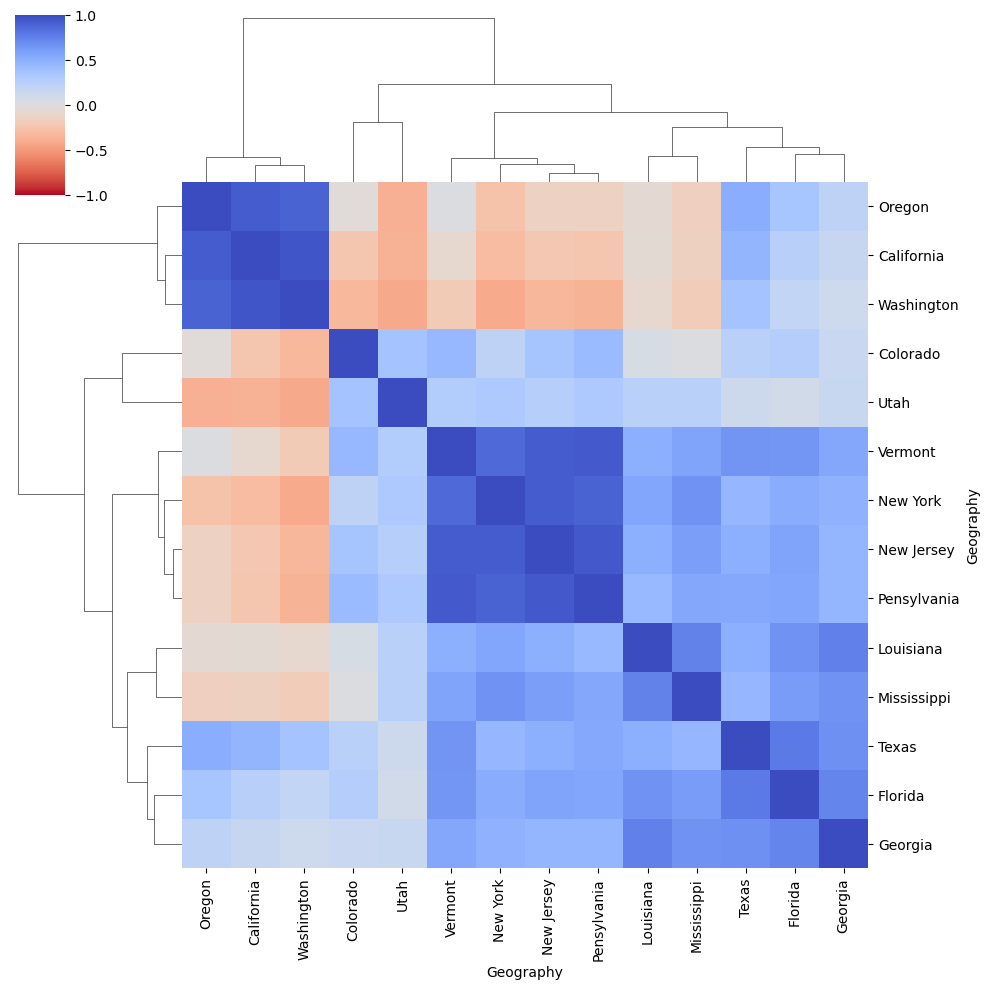

In [15]:
region = "South"
(analytic
  #.query("region_sales==@region")
  .pivot(index="Period", columns='Geography', values="VariableValue_sales_Test")
  .corr()
  .pipe(sns.clustermap, cmap="coolwarm_r", center=0, vmin=-1, vmax=1)
)

In [16]:
from patsy import dmatrix

In [17]:
splines = dmatrix("bs(x, df=6, degree=3, include_intercept=True) - 1", {"x": np.linspace(0, 1, 156)})
splines = np.asarray(splines, order='F')
spline_dims = np.arange(splines.shape[1])

In [18]:
365/7

52.142857142857146

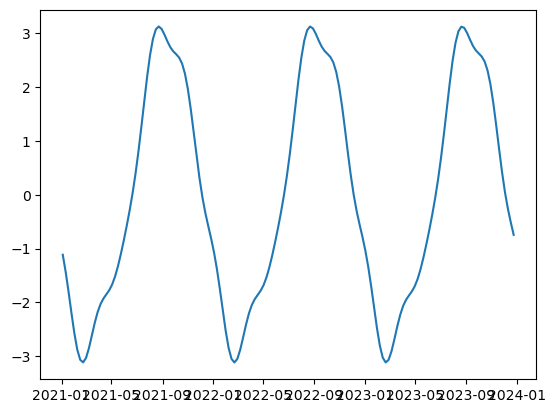

In [19]:
forier_components = np.array(
  [getattr(np, j)(2 * np.pi * i * np.linspace(0, 155, 156)/52.143)/i**1.5 for j in ['cos', 'sin'] for i in range(1, 6)]
)
plt.plot(time, np.random.normal(size=10)@forier_components)

In [20]:
analytic['Campaign_sales_Test'].values.reshape(len(time), len(geographies_reordered))

array([['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ...,
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West']], dtype=object)

In [21]:
analytic['VariableValue_sales_Test'].astype(float).values.reshape(len(time), len(geographies_reordered))

array([[-6.09381398, -0.20263791, -7.46187634, ...,  3.54242221,
        -2.78061365, -3.72525604],
       [-5.93820725, -0.67985351, -5.82066716, ...,  3.82276769,
        -3.29568504, -3.3309228 ],
       [-5.83947826,  0.81987054, -5.83126179, ...,  4.2950484 ,
        -2.53807724, -3.12705124],
       ...,
       [-1.02311527,  1.51797433, -3.45878887, ...,  1.64348351,
         0.81610713, -0.2395679 ],
       [-1.5969934 ,  1.39472017, -3.27085106, ...,  1.00136285,
         0.86237385,  1.09792181],
       [ 0.16872973,  2.15342935, -3.41391886, ...,  0.70817345,
         0.78220201, -0.06316989]])

In [22]:
analytic = analytic.sort_values(["Period", "Geography"])

In [23]:
region_factos, regions_keys = pd.factorize(analytic['Campaign_sales_Test'])

In [24]:
sorted(geographies)

['California',
 'Colorado',
 'Florida',
 'Georgia',
 'Louisiana',
 'Mississippi',
 'New Jersey',
 'New York',
 'Oregon',
 'Pensylvania',
 'Texas',
 'Utah',
 'Vermont',
 'Washington']

In [25]:
with pm.Model(coords = {
  'geo': sorted(geographies),
  'period': time,
  'region': regions_keys,
  'splines': spline_dims,
  'forier': np.arange(10)
}) as my_model:
  region_data = pm.Data("region_data", region_factos.reshape(len(time), len(geographies_reordered))[0, :], dims=("geo"))
  splines_data = pm.Data("splines_data", splines, dims=("period", "splines"))
  forier_data = pm.Data("forier_data", forier_components.T, dims=("period", "forier"))
  sales = pm.Data('sales', analytic['VariableValue_sales_Test'].astype(float).values.reshape(len(time), len(geographies_reordered)), dims=("period", "geo"))

  trends_betas_mu = pm.Normal("trends_betas_mu", mu=0, sigma=3, dims=("splines",))
  trends_betas_sd = pm.HalfNormal("trends_betas_sd", sigma=3, dims=("splines",))
  trends_betas = pm.Deterministic("trends_betas", trends_betas_mu[None, :] + trends_betas_sd[None, :] * pm.Normal("trends_betas_", mu=0, sigma=1, dims=("region", "splines")), dims=("region", "splines"))
  trends_betas_geo_sd = pm.HalfNormal("trends_betas_geo_sd", sigma=1, dims=("region"))
  trends_betas_geo = pm.Deterministic("trends_betas_geos", trends_betas[region_data, :] + trends_betas_geo_sd[region_data, None]*pm.Normal("trends_betas_geos_", mu=0, sigma=1, dims=("geo", "splines")), dims=("geo", "splines"))
  
  trends = pm.Deterministic('trends', (trends_betas_geo@splines_data.T).T, dims=("period", "geo"))

  forier_betas_mu = pm.Normal("forier_betas_mu", mu=0, sigma=3, dims=("forier",))
  forier_betas_sd = pm.HalfNormal("forier_betas_sd", sigma=3, dims=("forier",))
  forier_betas = pm.Deterministic("forier_betas", forier_betas_mu[None, :] + forier_betas_sd[None, :] * pm.Normal("forier_betas_", mu=0, sigma=1, dims=("region", "forier")), dims=('region', 'forier'))
  forier_betas_geo_sd = pm.HalfNormal("forier_betas_geo_sd", sigma=1, dims=("region"))
  forier_betas_geo = pm.Deterministic("forier_betas_geos", forier_betas[region_data, :] + forier_betas_geo_sd[region_data, None]*pm.Normal("forier_betas_geos_", mu=0, sigma=1, dims=("geo", "forier")), dims=("geo", "forier"))
  
  season = pm.Deterministic("season", (forier_betas_geo@forier_data.T).T, dims=("period", 'geo'))
  
  intercept_mu = pm.Normal("intercept", 0, 3, dims=('geo'))
  
  mu = pm.Deterministic('mu', season + trends + intercept_mu[None, :], dims=("period", 'geo'))
  
  sigma = pm.HalfNormal("sigma", sigma=3, dims=('geo'))
  cases = pm.Normal("cases", mu=mu, sigma=sigma, observed=sales, dims=("period", 'geo'))
  trace = pm.sample(1000, tune=1000, target_accept=0.99, nuts_sampler='numpyro')


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'trends_betas_geo_sd'}>,
        <Axes: title={'center': 'trends_betas_geo_sd'}>],
       [<Axes: title={'center': 'trends_betas_sd'}>,
        <Axes: title={'center': 'trends_betas_sd'}>]], dtype=object)

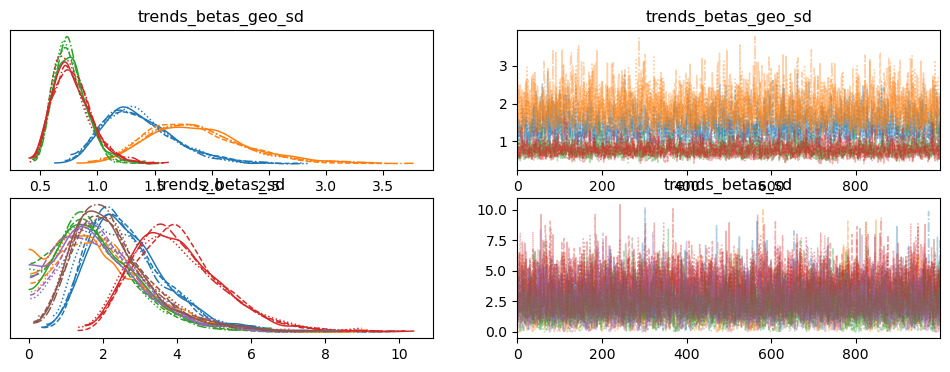

In [26]:
pm.plot_trace(trace, var_names=["trends_betas_geo_sd", "trends_betas_sd"])

In [50]:
with pm.Model() as beta_test:
    beta = pm.Beta("Beta_test", mu=.2, nu=10)
    

<Axes: ylabel='Count'>

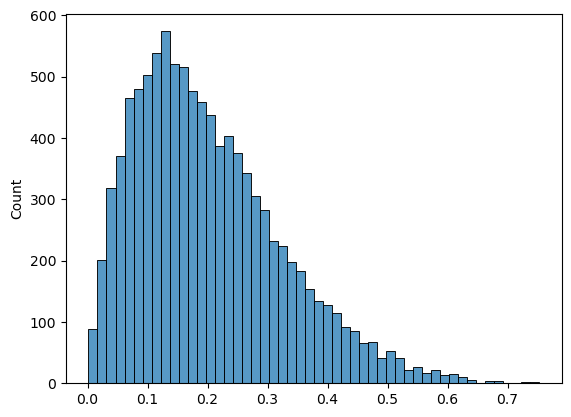

In [51]:
sns.histplot(pm.draw(beta, 10000))

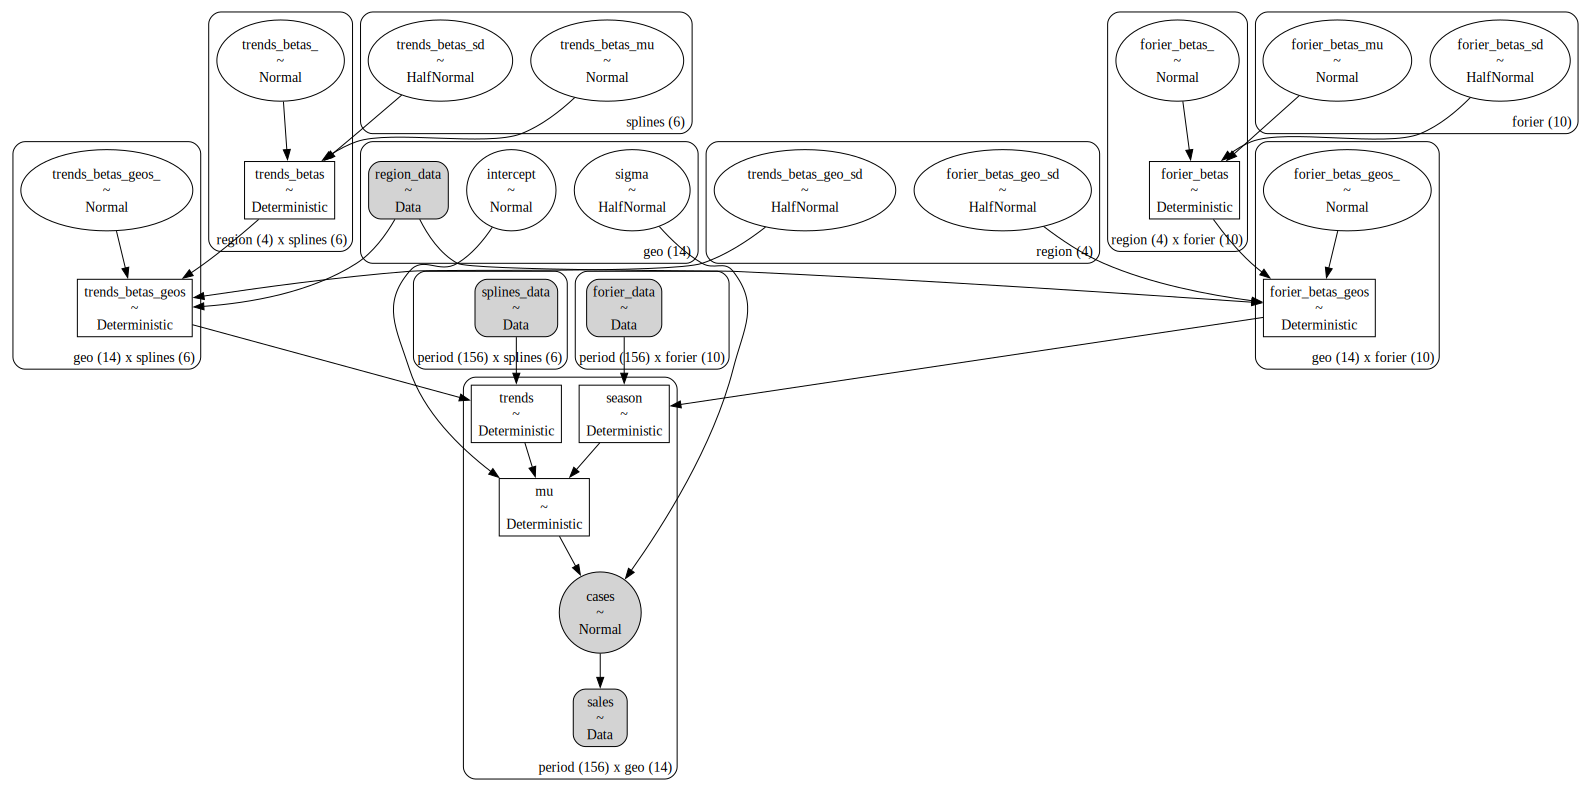

In [40]:
pm.model_to_graphviz(my_model)

In [41]:
trace.observed_data

<xarray.Dataset> Size: 19kB
Dimensions:  (period: 156, geo: 14)
Coordinates:
  * period   (period) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25
  * geo      (geo) <U11 616B 'California' 'Colorado' ... 'Vermont' 'Washington'
Data variables:
    cases    (period, geo) float64 17kB -6.094 -0.2026 ... 0.7822 -0.06317
Attributes:
    created_at:                 2024-09-04T17:42:50.209965+00:00
    arviz_version:              0.19.0
    inference_library:          numpyro
    inference_library_version:  0.15.2
    sampling_time:              169.201611
    tuning_steps:               1000

In [42]:
region_data.eval()

array([0, 1, 2, 2, 2, 2, 3, 3, 0, 3, 2, 1, 3, 0])

In [44]:
geos_ = analytic['Geography'].values.reshape(len(time), len(geographies_reordered))[0, :]


In [45]:
with my_model:
  pm.sample_posterior_predictive(trace, var_names=["cases"], extend_inferencedata=True)

Sampling: [cases]


Output()

In [46]:
trace.posterior_predictive.cases

<xarray.DataArray 'cases' (chain: 4, draw: 1000, period: 156, geo: 14)> Size: 70MB
array([[[[-6.94751550e+00, -4.23361878e-01, -5.61354106e+00, ...,
           3.77904101e+00, -1.10030826e+00, -4.85131786e+00],
         [-6.57332830e+00, -9.81269157e-01, -6.26801032e+00, ...,
           3.37485964e+00, -2.29208336e+00, -2.76735293e+00],
         [-5.51483908e+00, -7.36752302e-01, -5.81703375e+00, ...,
           3.21155325e+00, -1.68795589e+00, -3.02711428e+00],
         ...,
         [-6.43616187e-01,  2.71169780e+00, -2.98036855e+00, ...,
           2.40857566e+00,  1.10871028e+00,  1.17582860e-01],
         [-6.83850061e-01,  1.94816935e+00, -4.12102025e+00, ...,
           7.26335873e-01, -2.23099538e-02,  2.16492166e-01],
         [-8.39143396e-01,  2.81262611e+00, -4.50150072e+00, ...,
           3.40395968e-01, -1.80572403e-01,  1.35803456e+00]],

        [[-6.21717766e+00, -8.49861520e-01, -7.14689670e+00, ...,
           3.54432631e+00, -2.47708816e+00, -2.40957753e+00],
         [-5.75566178e+00, -1.23078577e+00, -6.87646128e+00, ...,
           2.47253017e+00, -1.93047487e+00, -3.23328259e+00],
         [-5.23755771e+00, -9.62269933e-01, -6.20485472e+00, ...,
           3.44328897e+00, -1.86090552e+00, -3.75379150e+00],
...
         [-1.19762527e-01,  2.60683860e+00, -4.56520971e+00, ...,
           1.17346059e+00,  1.16125466e+00, -1.16477509e-01],
         [-1.15375889e+00,  3.37813989e+00, -4.08548559e+00, ...,
           1.20424314e-01,  7.84261051e-01,  2.04620785e+00],
         [-8.25641728e-01,  1.62748443e+00, -4.47488643e+00, ...,
          -3.95990318e-01,  1.91301367e+00,  1.62232070e+00]],

        [[-6.59112268e+00, -7.71596205e-01, -6.52999872e+00, ...,
           3.79236002e+00, -2.49092598e+00, -3.65327011e+00],
         [-6.77340306e+00, -2.07217501e-01, -6.24307288e+00, ...,
           2.11449545e+00, -1.38925165e+00, -3.17413798e+00],
         [-4.09918473e+00,  4.23520803e-01, -7.03335469e+00, ...,
           3.37445136e+00, -1.03008171e+00, -2.84228093e+00],
         ...,
         [-1.13273441e+00,  2.75614683e+00, -3.64738240e+00, ...,
           1.56302566e-01,  8.28490216e-01,  8.48495367e-01],
         [-3.72206490e-01,  1.36216768e+00, -3.50427413e+00, ...,
           1.52160706e+00,  1.53390259e+00,  7.19613705e-01],
         [-4.03258315e-02,  2.28521709e+00, -4.17841156e+00, ...,
           2.55188750e-01,  5.91151352e-01,  1.74491112e+00]]]])
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * period   (period) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25
  * geo      (geo) <U11 616B 'California' 'Colorado' ... 'Vermont' 'Washington'

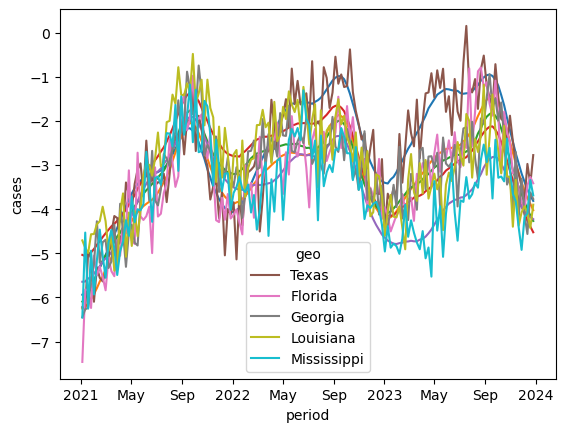

In [47]:
GEO = regions['South']
trace.posterior_predictive["cases"].mean(dim=("chain", "draw")).sel({"geo": GEO}).plot.line(x='period', hue='geo')
trace.observed_data.cases.sel({"geo": GEO}).plot.line(x="period", hue="geo")


In [48]:
hdi = pm.hdi(trace.posterior_predictive.cases, hdi_prob=0.89)
hdi

<xarray.Dataset> Size: 37kB
Dimensions:  (period: 156, geo: 14, hdi: 2)
Coordinates:
  * period   (period) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25
  * geo      (geo) <U11 616B 'California' 'Colorado' ... 'Vermont' 'Washington'
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    cases    (period, geo, hdi) float64 35kB -7.684 -5.625 ... 0.05179 1.968

In [49]:
trace_expanded = trace.posterior.assign(trend_intercept=lambda x: x.intercept + x.trends)

Text(0.5, 0.98, 'Trends')

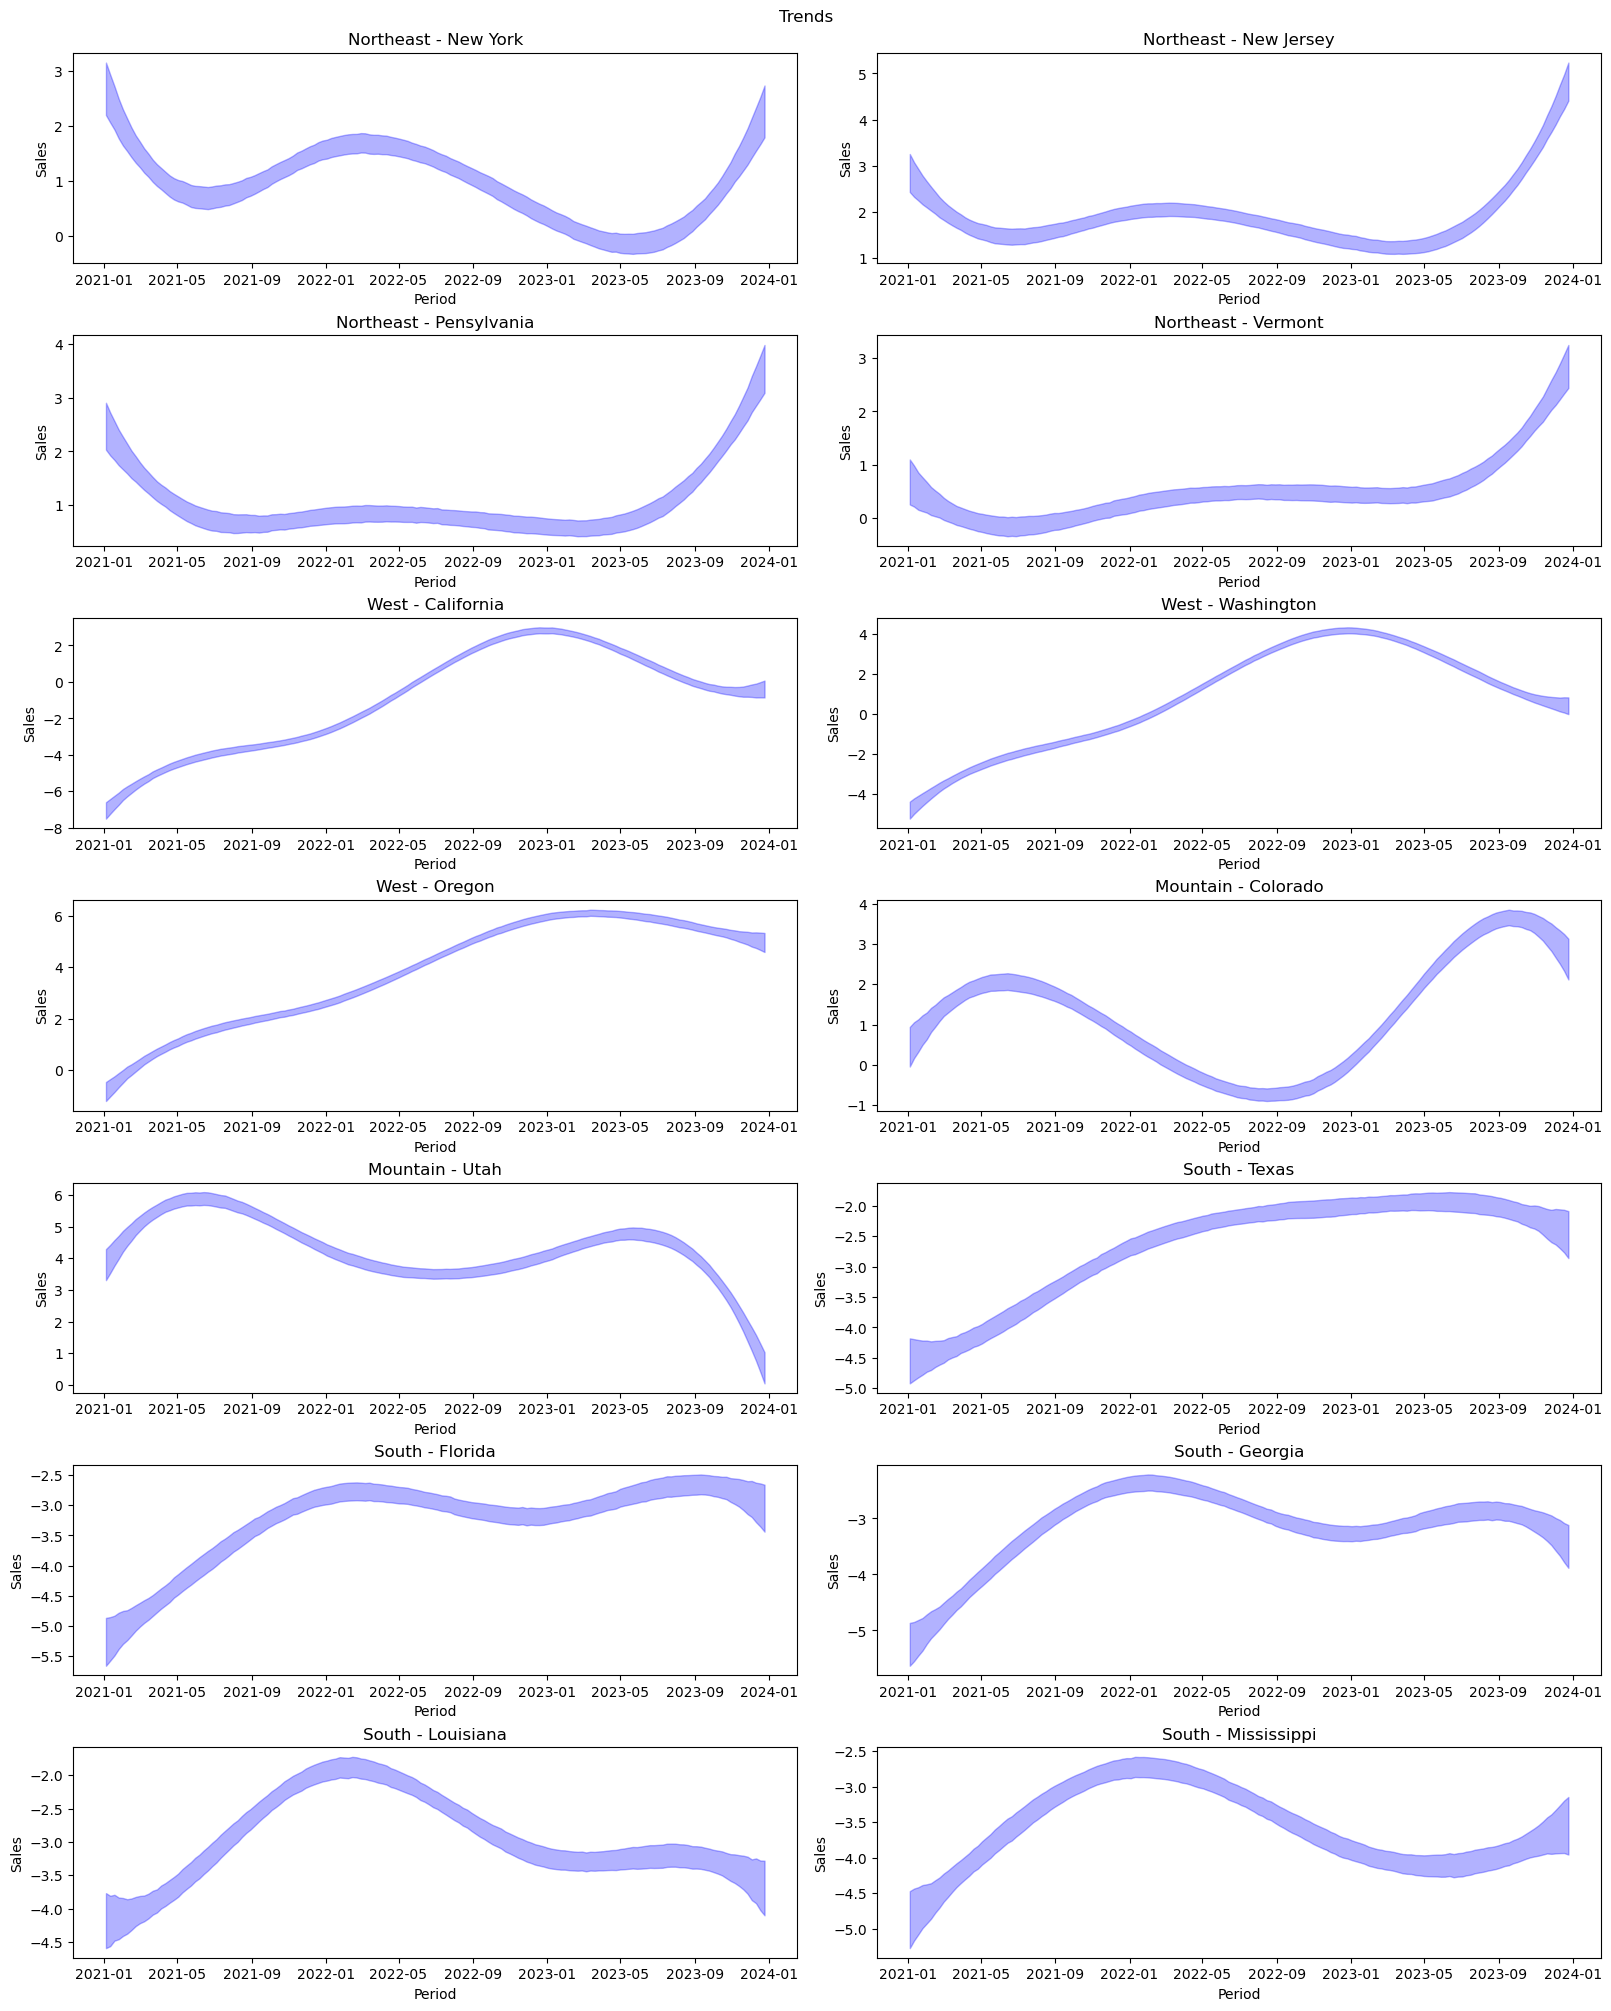

In [50]:
GEO = geographies[10]
fig, ax = plt.subplots(7, 2, figsize=(16, 20), layout="constrained")
hdi = pm.hdi(trace_expanded.trend_intercept, hdi_prob=0.89).trend_intercept
mean_cases = trace.posterior_predictive.cases.mean(dim=("chain", "draw"))
for i, GEO in enumerate(geographies):
  j, i_ = i//2, i%2
  #ax[j, i_].plot(time, mean_cases.sel({"geo": GEO}).values, c='b')
  #ax[j, i_].scatter(time, trace.observed_data.cases.sel({"geo": GEO}).values, c='k')
  ax[j, i_].fill_between(time, hdi.sel({"geo": GEO}).sel({"hdi": "lower"}).values, hdi.sel({"geo": GEO}).sel({"hdi": "higher"}).values, alpha=0.3, color='b')
  ax[j, i_].set_title(f"{region_map[GEO]} - {GEO}")
  ax[j, i_].set_ylabel("Sales")
  ax[j, i_].set_xlabel("Period")
plt.suptitle("Trends")

Text(0.5, 0.98, 'Seasons')

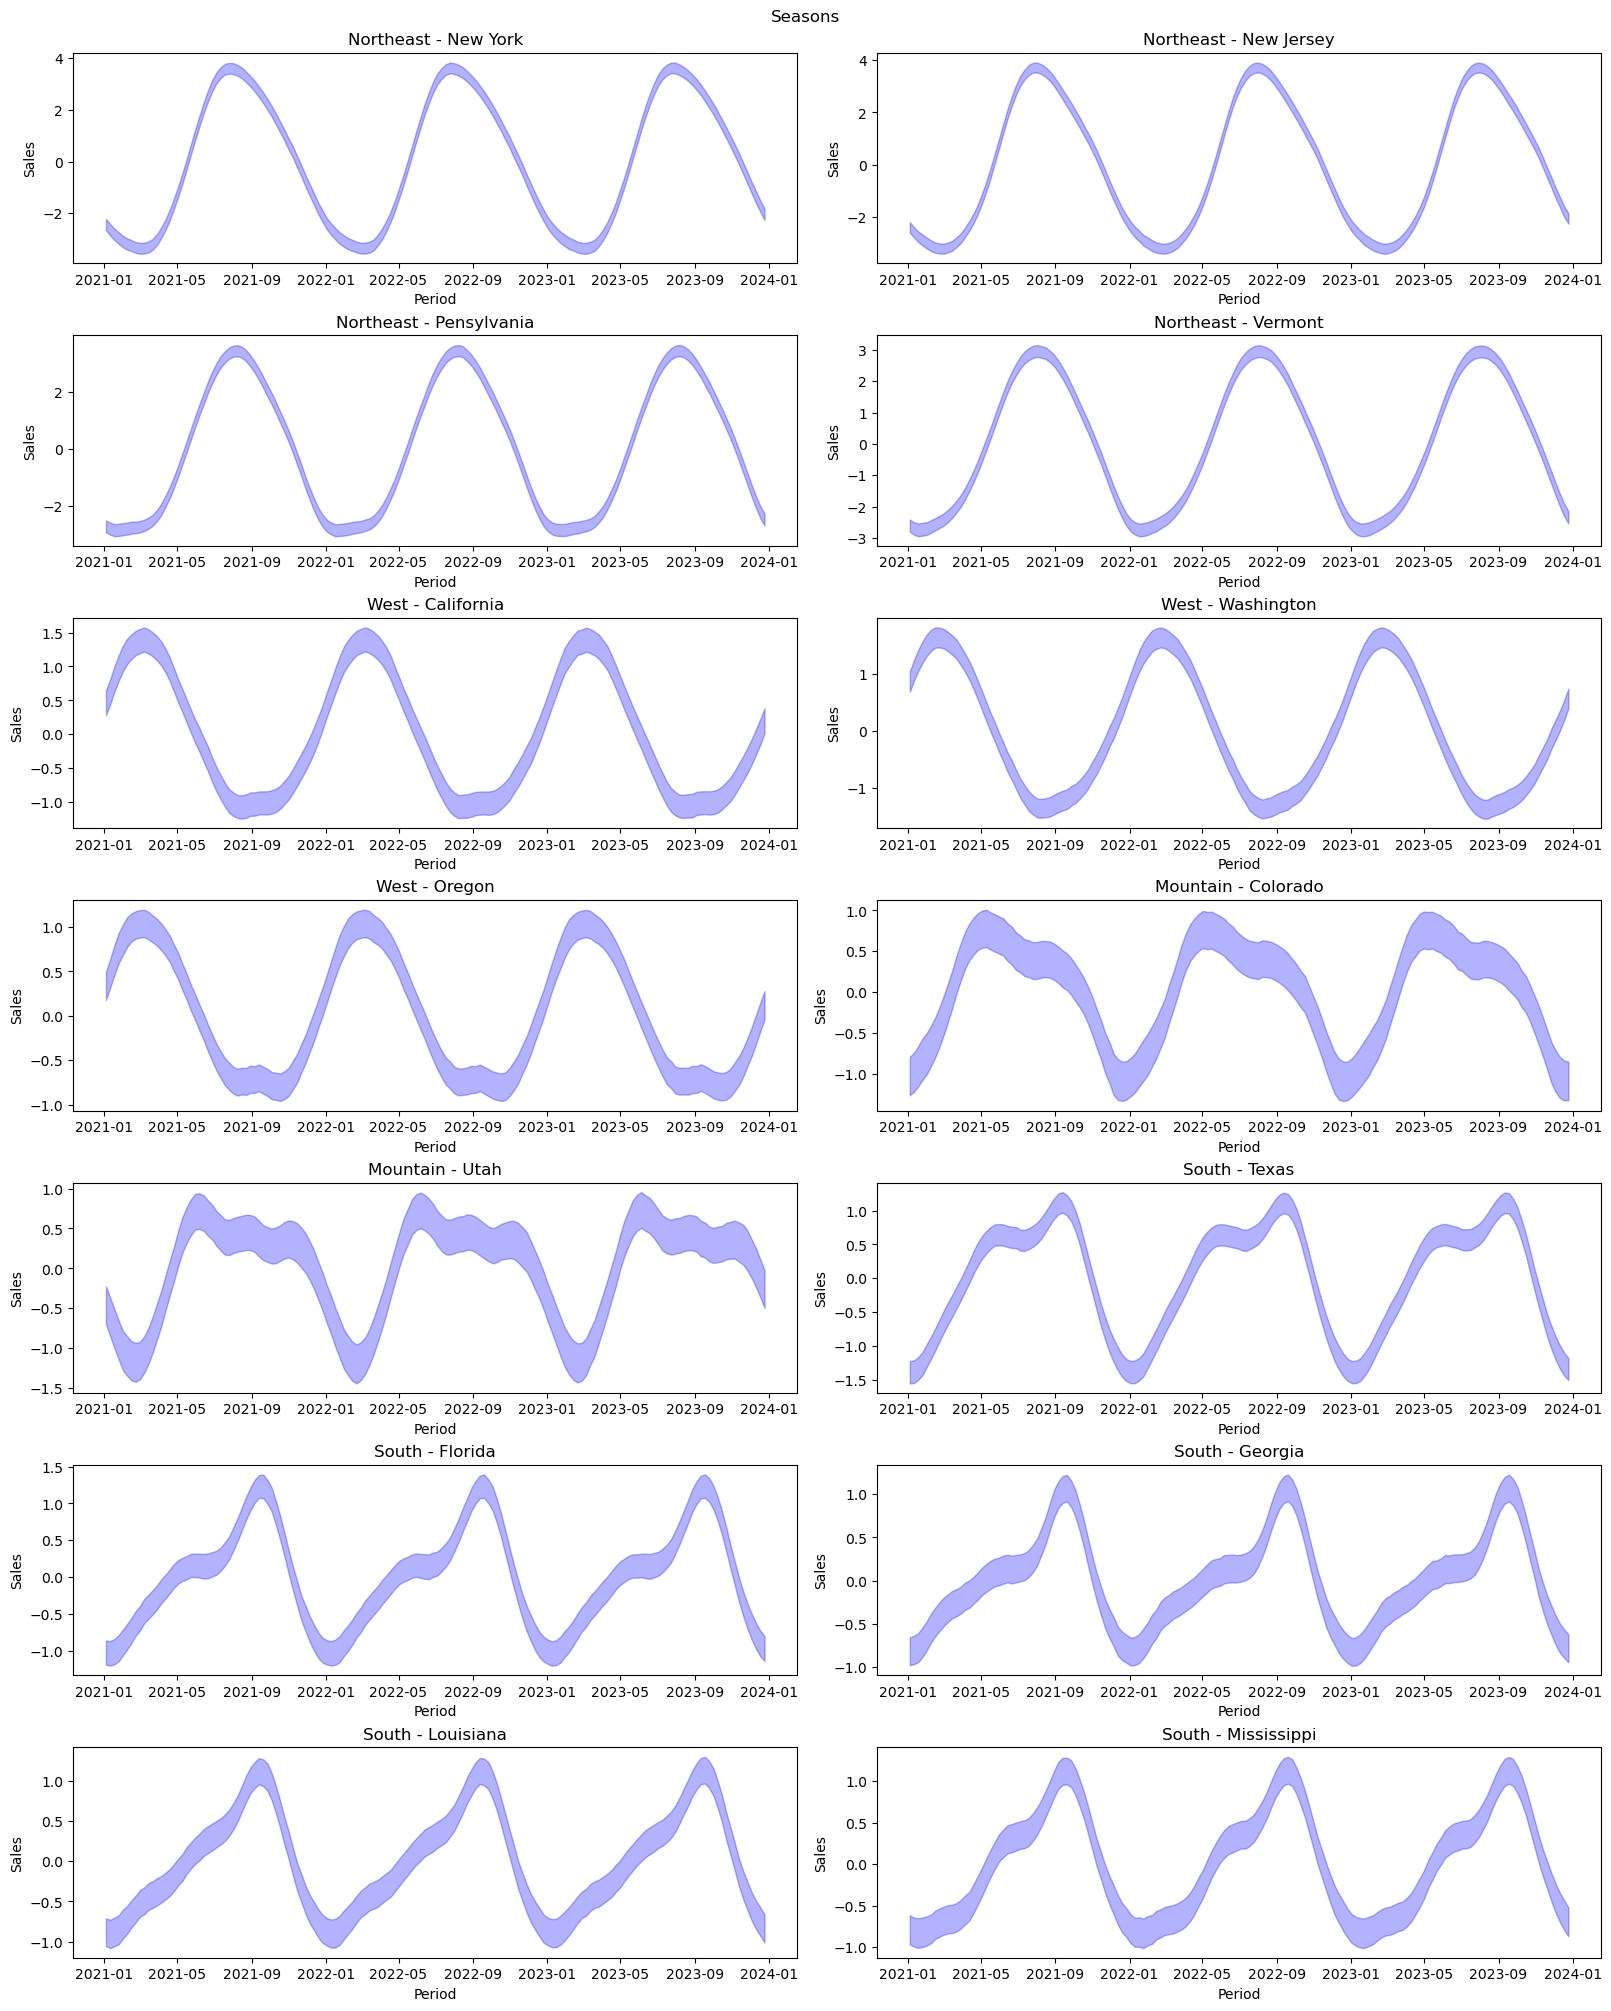

In [51]:
GEO = geographies[10]
fig, ax = plt.subplots(7, 2, figsize=(16, 20), layout="constrained")
hdi = pm.hdi(trace_expanded.season, hdi_prob=0.89).season
mean_cases = trace.posterior_predictive.cases.mean(dim=("chain", "draw"))
for i, GEO in enumerate(geographies):
  j, i_ = i//2, i%2
  #ax[j, i_].plot(time, mean_cases.sel({"geo": GEO}).values, c='b')
  #ax[j, i_].scatter(time, trace.observed_data.cases.sel({"geo": GEO}).values, c='k')
  ax[j, i_].fill_between(time, hdi.sel({"geo": GEO}).sel({"hdi": "lower"}).values, hdi.sel({"geo": GEO}).sel({"hdi": "higher"}).values, alpha=0.3, color='b')
  ax[j, i_].set_title(f"{region_map[GEO]} - {GEO}")
  ax[j, i_].set_ylabel("Sales")
  ax[j, i_].set_xlabel("Period")
plt.suptitle("Seasons")